In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
# from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
import cv2
from sklearn.cluster import DBSCAN
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

pose_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_pose/session_pose_info'
os.makedirs(pose_analysis_session_data,exist_ok=True)

case_study_input_data = f'{SERVER_CACHE_DIR}/case_studies_input_raw/'
os.makedirs(case_study_input_data,exist_ok=True)


embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

in_session_median_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_median_embeddings'
os.makedirs(in_session_median_embeddings_data_dir, exist_ok=True)

in_session_cluster_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_cluster_embeddings'
os.makedirs(in_session_cluster_embeddings_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
session_filter_list = [
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
]

results_dir = f'results/20231120'
os.makedirs(results_dir, exist_ok=True)

In [3]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]        
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [4]:
def frame_to_timestamp(frameNumber):
    return pd.to_timedelta(int(frameNumber*1000/15),unit='ms')

In [119]:
handraise_dfs = []
hand_positions = {'other':0, 'error':0, 'handsOnFace':0, 'armsCrossed':0, 'handsRaised':1}
for session_idx, session_id in enumerate(session_filter_list):
    case_study_input_cache_file = f"{case_study_input_data}/{session_id}-front.pb"
    instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))
    ts_data_dfs = []
    sid_idx = 0
    for sid in sorted(list(posture_info.keys())):
        if sid not in instructor_ids:
            handraise_sid = deepcopy(posture_info[sid]).reset_index()
            handraise_sid['time'] = handraise_sid['frame']//(60*15)
            handraise_sid['hand_raised'] = handraise_sid.armPose.apply(lambda x: hand_positions[x])
            handraise_sid = handraise_sid.groupby('time',as_index=False).agg({'hand_raised':lambda x: x.sum()>0})
            handraise_sid = handraise_sid[handraise_sid['hand_raised']==1]
            handraise_sid['StudentID'] = sid_idx
            sid_idx+=1
            handraise_sid = handraise_sid[['StudentID','time','hand_raised']]
            handraise_sid['session'] = session_id
            ts_data_dfs.append(handraise_sid)
    
    df_handraise_session = pd.concat(ts_data_dfs)
    handraise_dfs.append(df_handraise_session)
    print(f"Got session {session_id}")



KeyboardInterrupt



In [ ]:
df_handraises = pd.concat(handraise_dfs)
df_handraises.info()
df_handraises.head()

In [5]:
# df_handraises.to_csv(f'{results_dir}/handraise_times.csv',index=False)
df_handraises = pd.read_csv(f'{results_dir}/handraise_times.csv')


# Across Student for 5 students 

In [129]:
course = '05748A'
df_session_hand_raises  = df_handraises.groupby(['session','StudentID'],as_index=False)['time'].count()
df_session_hand_raises = df_session_hand_raises[df_session_hand_raises.session.apply(lambda x: course in x)]
df_session_hand_raises.sort_values(by='time',ascending=False)

,session,StudentID,time
23,classinsight-cmu_05748A_ghc_4101_201902141630,6,32
42,classinsight-cmu_05748A_ghc_4101_201902281630,6,29
84,classinsight-cmu_05748A_ghc_4101_201904021630,13,26
79,classinsight-cmu_05748A_ghc_4101_201904021630,8,20
59,classinsight-cmu_05748A_ghc_4101_201903071630,4,19
...,...,...,...
78,classinsight-cmu_05748A_ghc_4101_201904021630,7,1
61,classinsight-cmu_05748A_ghc_4101_201903071630,6,1
50,classinsight-cmu_05748A_ghc_4101_201902281630,15,1
1,classinsight-cmu_05748A_ghc_4101_201902051630,1,1


In [130]:
df_session_hand_raises.session.unique()

array(['classinsight-cmu_05748A_ghc_4101_201902051630',
       'classinsight-cmu_05748A_ghc_4101_201902141630',
       'classinsight-cmu_05748A_ghc_4101_201902281630',
       'classinsight-cmu_05748A_ghc_4101_201903071630',
       'classinsight-cmu_05748A_ghc_4101_201904021630'], dtype=object)

In [131]:
df_session_hand_raises['sid'] = df_session_hand_raises.apply(lambda row: f'{row["session"].split("_")[-1][-8:-4]}_{row["StudentID"]}', axis=1)
df_session_hand_raises.head()

,session,StudentID,time,sid
0,classinsight-cmu_05748A_ghc_4101_201902051630,0,1,0205_0
1,classinsight-cmu_05748A_ghc_4101_201902051630,1,1,0205_1
2,classinsight-cmu_05748A_ghc_4101_201902051630,2,5,0205_2
3,classinsight-cmu_05748A_ghc_4101_201902051630,4,4,0205_4
4,classinsight-cmu_05748A_ghc_4101_201902051630,5,1,0205_5


In [132]:

df_across_session = pd.read_csv(f'results/across_session_constrained_matches_{course}.csv')
df_across_session

,sessionA,sessionB,idA,idB,gt,pred
0,205.0,214.0,0205_0,0214_2,1.0,0.0
1,205.0,214.0,0205_1,0214_0,1.0,1.0
2,205.0,214.0,0205_3,0214_12,1.0,0.0
3,205.0,214.0,0205_14,0214_1,1.0,1.0
4,205.0,214.0,0205_5,0214_10,1.0,0.0
...,...,...,...,...,...,...
168,NaN,NaN,0214_8,0402_4,0.0,1.0
169,NaN,NaN,0214_6,0402_8,0.0,1.0
170,NaN,NaN,0228_3,0307_17,0.0,1.0
171,NaN,NaN,0228_8,0307_4,0.0,1.0


In [133]:
session_maps = {
    '0205':'classinsight-cmu_05748A_ghc_4101_201902051630',
    '0214':'classinsight-cmu_05748A_ghc_4101_201902141630',
    '0228':'classinsight-cmu_05748A_ghc_4101_201902281630',
    '0307':'classinsight-cmu_05748A_ghc_4101_201903071630',
    '0402':'classinsight-cmu_05748A_ghc_4101_201904021630'
}

In [134]:
# df_across_session[(df_across_session['gt']==0) & (df_across_session['pred']==1)]

# GT and Pred Based Student performance distribution

In [135]:
df_across_session_gt =  df_across_session[df_across_session['gt']==1][['idA','idB']].drop_duplicates()
df_across_session_gt

,idA,idB
0,0205_0,0214_2
1,0205_1,0214_0
2,0205_3,0214_12
3,0205_14,0214_1
4,0205_5,0214_10
...,...,...
154,0307_3,0402_4
155,0307_3,0402_7
156,0307_13,0402_6
157,0307_5,0402_0


In [136]:
df_across_session_pred =  df_across_session[df_across_session['pred']==1][['idA','idB']].drop_duplicates()
# df_across_session_pred.reset_index(drop=True).to_csv(f'results/across_session_prediction_matches_{course}.csv')
df_across_session_pred.shape

(54, 2)

In [137]:
reference_session_matches_gt = {}
new_set_idx=0
for row_idx, row in df_across_session_gt.iterrows():
    idA, idB = row['idA'], row['idB']
    is_new_set=True
    for set_idx in reference_session_matches_gt:
        if idA in reference_session_matches_gt[set_idx]:
            reference_session_matches_gt[set_idx].add(idB)
            is_new_set=False
            break
        elif idB in reference_session_matches_gt[set_idx]:
            reference_session_matches_gt[set_idx].add(idA)
            is_new_set=False
            break
    if is_new_set:
        reference_session_matches_gt[new_set_idx] = {idA,idB}
        new_set_idx+=1
        
reference_session_matches_gt  

{0: {'0205_0',
  '0205_19',
  '0214_14',
  '0214_2',
  '0228_27',
  '0228_8',
  '0307_9',
  '0402_13',
  '0402_5'},
 1: {'0205_1', '0214_0', '0228_15', '0402_1'},
 2: {'0205_3', '0214_12', '0228_3', '0307_6', '0402_14'},
 3: {'0205_14', '0214_1', '0228_5', '0307_1', '0402_2'},
 4: {'0205_5', '0214_10', '0228_18', '0307_0', '0402_10'},
 5: {'0205_12',
  '0205_13',
  '0205_16',
  '0205_6',
  '0205_9',
  '0214_3',
  '0214_4',
  '0214_6',
  '0214_7',
  '0214_8',
  '0214_9',
  '0228_1',
  '0228_12',
  '0228_16',
  '0228_19',
  '0228_7',
  '0228_9',
  '0307_11',
  '0307_13',
  '0307_17',
  '0307_3',
  '0307_5',
  '0307_7',
  '0402_0',
  '0402_3',
  '0402_4',
  '0402_6',
  '0402_7',
  '0402_8'},
 6: {'0205_7', '0214_5', '0228_0'},
 7: {'0205_9', '0214_9', '0228_1'},
 8: {'0205_10', '0214_7', '0228_12', '0307_7', '0402_4'},
 9: {'0205_11', '0214_17', '0228_2', '0307_4', '0402_11'},
 10: {'0205_13', '0214_3'},
 11: {'0205_16', '0214_6', '0228_16', '0228_19', '0307_5'},
 12: {'0205_19', '0214_14

In [138]:
reference_session_matches_pred = {}
new_set_idx=0
for row_idx, row in df_across_session_pred.iterrows():
    idA, idB = row['idA'], row['idB']
    is_new_set=True
    for set_idx in reference_session_matches_pred:
        if idA in reference_session_matches_pred[set_idx]:
            reference_session_matches_pred[set_idx].add(idB)
            is_new_set=False
            break
        elif idB in reference_session_matches_pred[set_idx]:
            reference_session_matches_pred[set_idx].add(idA)
            is_new_set=False
            break
    if is_new_set:
        reference_session_matches_pred[new_set_idx] = {idA,idB}
        new_set_idx+=1
        
reference_session_matches_pred
# reference_session_matches_pred = {id: reference_session_matches_pred[id] for id in reference_session_matches_pred if len(list(reference_session_matches_pred[id]))>=3}
reference_session_matches_pred, reference_session_matches_gt

# reference_session_matches_pred = {}
# for row_idx, row in df_across_session_pred.iterrows():
#     idA, idB = row['idA'], row['idB']
#     if reference_session in idA:
#         if idA in reference_session_matches_pred:
#             reference_session_matches_pred[idA].append(idB)
#         else:
#             reference_session_matches_pred[idA] = [idB]
#     elif reference_session in idB:
#         if idB in reference_session_matches_pred:
#             reference_session_matches_pred[idB].append(idA)
#         else:
#             reference_session_matches_pred[idB] = [idA]
# reference_session_matches_pred  

({0: {'0205_1', '0214_0', '0228_15', '0402_1'},
  1: {'0205_14', '0214_1', '0228_3', '0228_5', '0307_17', '0307_5'},
  2: {'0205_7', '0214_2', '0214_5', '0228_0'},
  3: {'0205_9', '0214_9', '0228_1', '0307_3', '0402_3'},
  4: {'0205_10', '0214_7', '0307_7'},
  5: {'0205_0', '0205_11', '0214_17', '0228_2', '0228_8', '0307_4', '0402_11'},
  6: {'0205_19', '0214_14'},
  7: {'0205_12', '0228_19', '0307_11'},
  8: {'0205_15', '0228_13', '0307_10'},
  9: {'0205_13', '0214_2', '0214_8', '0228_12', '0402_4', '0402_6'},
  10: {'0214_3', '0228_7', '0307_13'},
  11: {'0214_20', '0228_6'},
  12: {'0214_12', '0307_6', '0402_14'},
  13: {'0214_10', '0228_18', '0307_0', '0402_10'},
  14: {'0214_8', '0307_11'},
  15: {'0214_6', '0307_5', '0402_8'},
  16: {'0228_16', '0402_0'},
  17: {'0205_16', '0307_17', '0402_7'},
  18: {'0214_4', '0228_8'}},
 {0: {'0205_0',
   '0205_19',
   '0214_14',
   '0214_2',
   '0228_27',
   '0228_8',
   '0307_9',
   '0402_13',
   '0402_5'},
  1: {'0205_1', '0214_0', '0228_15

In [139]:
# get handraise performances for reference session and its distribution
reference_handraises = []
for ref_sid_idx, ref_sid in enumerate(reference_session_matches_gt.keys()):
    sid_matches = reference_session_matches_gt[ref_sid]
    try:
        for matched_sid in sid_matches:
            try:
                sid_handraise_count = df_session_hand_raises[df_session_hand_raises.sid==matched_sid].time.values[0]
                # print(matched_sid, sid_handraise_count)
                # studentID = int(ref_sid.split("_")[1])
                reference_handraises.append([ref_sid, matched_sid, sid_handraise_count])
            except:
                continue
    except:
        continue
df_ref_handraise_gt = pd.DataFrame(reference_handraises, columns =['StudentID','StudentName','participation'])
df_ref_handraise_gt
    

,StudentID,StudentName,participation
0,0,0205_0,1
1,0,0228_8,1
2,0,0214_2,17
3,0,0214_14,11
4,0,0402_13,26
...,...,...,...
79,14,0228_19,6
80,15,0228_13,7
81,15,0205_15,10
82,16,0307_16,1


In [140]:
# get handraise performances for reference session and its distribution
reference_handraises = []
for ref_sid_idx, ref_sid in enumerate(reference_session_matches_pred.keys()):
    sid_matches = reference_session_matches_pred[ref_sid]
    # print(sid_matches)
    try:
        for matched_sid in sid_matches:
            try:
                sid_handraise_count = df_session_hand_raises[df_session_hand_raises.sid==matched_sid].time.values[0]
                reference_handraises.append([ref_sid, matched_sid, sid_handraise_count])
            except:
                continue
    except:
        continue
df_ref_handraise_pred = pd.DataFrame(reference_handraises, columns =['StudentID','StudentName','participation'])
df_ref_handraise_pred

,StudentID,StudentName,participation
0,0,0205_1,1
1,0,0214_0,7
2,0,0228_15,1
3,1,0214_1,11
4,1,0307_5,4
...,...,...,...
57,17,0402_7,1
58,17,0205_16,14
59,17,0307_17,1
60,18,0228_8,1


In [141]:
df_ref_handraise_gt['type']='Ground Truth'
df_ref_handraise_pred['type']='Prediction'

df_ref_handraise = pd.concat([df_ref_handraise_gt, df_ref_handraise_pred])
df_ref_handraise.head(), df_ref_handraise.tail()

(   StudentID StudentName  participation          type
 0          0      0205_0              1  Ground Truth
 1          0      0228_8              1  Ground Truth
 2          0      0214_2             17  Ground Truth
 3          0     0214_14             11  Ground Truth
 4          0     0402_13             26  Ground Truth,
     StudentID StudentName  participation        type
 57         17      0402_7              1  Prediction
 58         17     0205_16             14  Prediction
 59         17     0307_17              1  Prediction
 60         18      0228_8              1  Prediction
 61         18      0214_4              9  Prediction)

<Axes: xlabel='StudentID', ylabel='participation'>

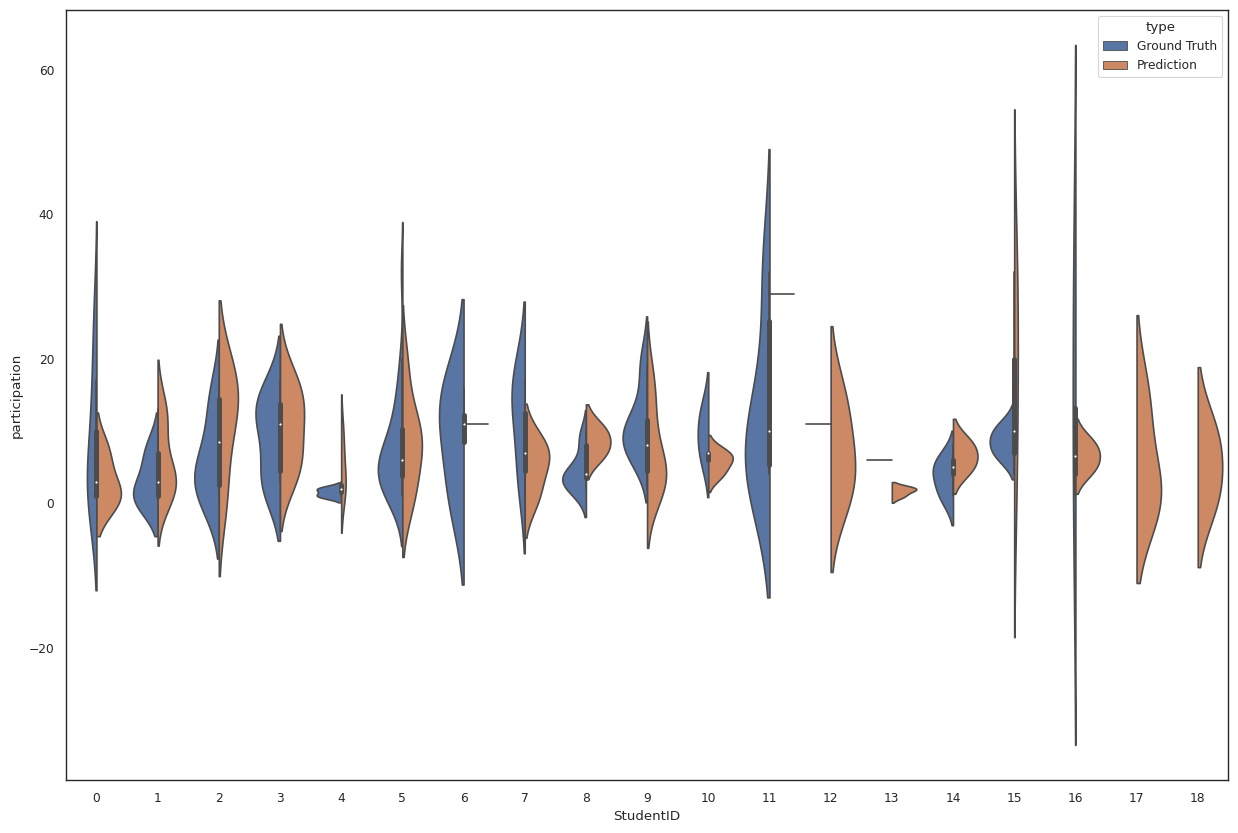

In [142]:
fig, axn = plt.subplots(1,1, figsize= (15,10))
sns.violinplot(data=df_ref_handraise, x='StudentID',y='participation', hue='type', split=True, ax = axn)
# sns.scatterplot(data=df_ref_handraise, x='StudentID',y='ref', ax = axn, color='#c44e52', marker="_",s=1000)

In [143]:
df_ref_handraise.to_csv(f'CS_1C_across_session_{course}.csv',index=False)

In [86]:
# selected_students = [0,1,2,5,7,8,12,13,15,16,19]
# df_ref_handraise[df_ref_handraise.StudentID.isin(selected_students)].to_csv('CS_1C_dist_across_session.csv', index=False)

In [86]:
# df_session_hand_raises

,session,StudentID,time,sid
0,classinsight-cmu_05748A_ghc_4101_201902051630,0,1,0205_0
1,classinsight-cmu_05748A_ghc_4101_201902051630,1,1,0205_1
2,classinsight-cmu_05748A_ghc_4101_201902051630,2,5,0205_2
3,classinsight-cmu_05748A_ghc_4101_201902051630,4,4,0205_4
4,classinsight-cmu_05748A_ghc_4101_201902051630,5,1,0205_5
...,...,...,...,...
85,classinsight-cmu_05748A_ghc_4101_201904021630,14,14,0402_14
86,classinsight-cmu_05748A_ghc_4101_201904021630,15,6,0402_15
87,classinsight-cmu_05748A_ghc_4101_201904021630,16,7,0402_16
88,classinsight-cmu_05748A_ghc_4101_201904021630,18,5,0402_18
